# SD Neighborhood Pulse Phase 3 EDA
This notebook profiles frustration-index behavior, identifies top-N request-volume peak days, and tracks Unknown-rate quality trends for neighborhood dimensions.

In [1]:
from pathlib import Path

import duckdb
import pandas as pd
import plotly.express as px

DB_PATH = Path('../data/db/city_health.duckdb')
assert DB_PATH.exists(), f'Missing DuckDB file: {DB_PATH.resolve()}'

In [3]:
con = duckdb.connect(str(DB_PATH), read_only=True)
frustration = con.execute('select * from fct_neighborhood_frustration_index').fetchdf()
daily_metrics = con.execute('select * from fct_neighborhood_daily_metrics').fetchdf()
hotspots = con.execute('select * from fct_request_hotspots').fetchdf()

print('frustration rows:', len(frustration))
print('daily metrics rows:', len(daily_metrics))
print('hotspots rows:', len(hotspots))
frustration.head()

frustration rows: 1002228
daily metrics rows: 113959
hotspots rows: 4319


,as_of_date,grain_type,grain_value,grain_geo_value,is_primary_grain,window_days,request_count,open_request_count,aging_open_request_count,duplicate_child_request_count,avg_resolution_days,backlog_component,aging_component,repeat_component,resolution_component,frustration_index
0,2017-05-17,zipcode,91942,91942,False,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-05-18,zipcode,91942,91942,False,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-05-19,zipcode,91942,91942,False,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-05-20,zipcode,91942,91942,False,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-05-21,zipcode,91942,91942,False,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


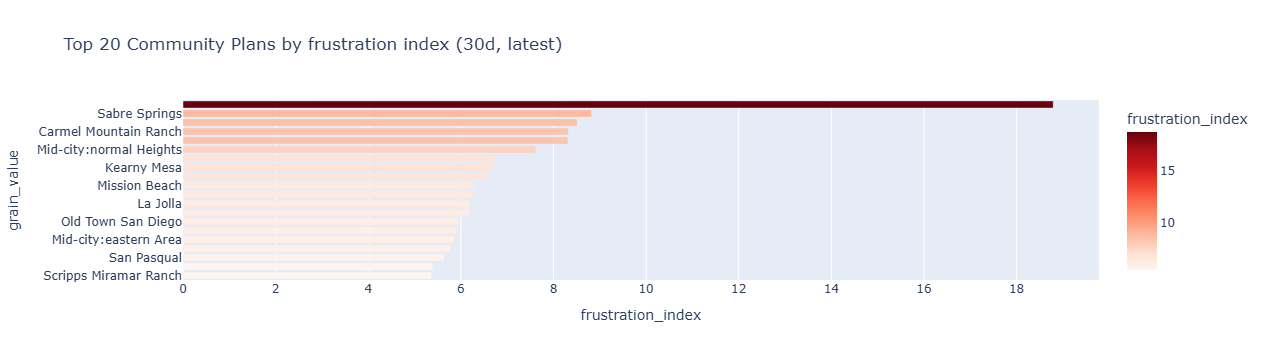

In [4]:
latest = frustration['as_of_date'].max()
focus = frustration[
    (frustration['as_of_date'] == latest)
    & (frustration['window_days'] == 30)
    & (frustration['grain_type'] == 'comm_plan_name')
    & (frustration['grain_value'] != 'Unknown')
].sort_values('frustration_index', ascending=False).head(20)

fig = px.bar(
    focus,
    x='frustration_index',
    y='grain_value',
    orientation='h',
    color='frustration_index',
    color_continuous_scale='Reds',
    title='Top 20 Community Plans by frustration index (30d, latest)'
)
fig.update_layout(yaxis={'categoryorder': 'total ascending'})
fig

Top 10 peak-volume days for Ncfua Subarea Ii


,as_of_date,request_count,frustration_index,driver_component,backlog_component,aging_component,repeat_component,resolution_component
108960,2025-11-29,13.0,8.49,Repeat Requests,0.0,0.0,23.08,10.89
108683,2025-02-25,13.0,6.31,Resolution Lag,0.0,0.0,0.00,25.22
109005,2026-01-13,12.0,1.53,Resolution Lag,0.0,0.0,0.00,6.11
108958,2025-11-27,12.0,6.25,Repeat Requests,0.0,0.0,16.67,8.33
108961,2025-11-30,12.0,7.25,Repeat Requests,0.0,0.0,16.67,12.33
108959,2025-11-28,12.0,6.25,Repeat Requests,0.0,0.0,16.67,8.33
109006,2026-01-14,12.0,1.53,Resolution Lag,0.0,0.0,0.00,6.11
108954,2025-11-23,12.0,6.25,Repeat Requests,0.0,0.0,16.67,8.33
108955,2025-11-24,12.0,6.25,Repeat Requests,0.0,0.0,16.67,8.33
108956,2025-11-25,12.0,6.25,Repeat Requests,0.0,0.0,16.67,8.33


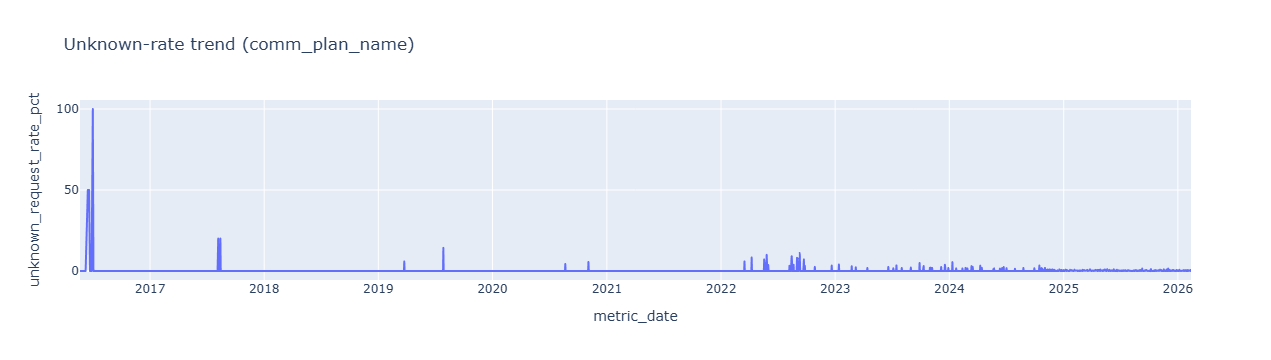

In [5]:
target_grain = 'comm_plan_name'
target_value = focus.iloc[0]['grain_value'] if not focus.empty else None
peak_n = 10

if target_value is None:
    print('No focus rows available for peak analysis.')
else:
    trend = frustration[
        (frustration['grain_type'] == target_grain)
        & (frustration['grain_value'] == target_value)
        & (frustration['window_days'] == 30)
    ].sort_values('as_of_date')

    component_cols = ['backlog_component', 'aging_component', 'repeat_component', 'resolution_component']
    component_labels = {
        'backlog_component': 'Backlog Pressure',
        'aging_component': 'Aging Open Cases',
        'repeat_component': 'Repeat Requests',
        'resolution_component': 'Resolution Lag',
    }

    peak_days = trend.sort_values('request_count', ascending=False).head(peak_n).copy()
    peak_days['driver_component'] = peak_days[component_cols].astype(float).idxmax(axis=1).map(component_labels)

    print(f'Top {peak_n} peak-volume days for {target_value}')
    display(peak_days[['as_of_date', 'request_count', 'frustration_index', 'driver_component'] + component_cols])

    quality = daily_metrics[daily_metrics['grain_type'] == target_grain].copy()
    quality['is_unknown'] = quality['grain_value'] == 'Unknown'
    unknown = (
        quality.groupby('metric_date', as_index=False)
        .agg(
            request_count=('request_count', 'sum'),
            unknown_request_count=('request_count', lambda s: s[quality.loc[s.index, 'is_unknown']].sum()),
        )
    )
    unknown['unknown_request_rate_pct'] = (
        unknown['unknown_request_count'] / unknown['request_count'].where(unknown['request_count'] != 0, 1)
    ) * 100

    fig_unknown = px.line(
        unknown,
        x='metric_date',
        y='unknown_request_rate_pct',
        title=f'Unknown-rate trend ({target_grain})',
    )
    fig_unknown.show()

    hotspots.sort_values(['window_days', 'request_count'], ascending=[True, False]).head(25)

## Phase 4 component sensitivity quick-check
Use this section to sanity-check whether each frustration component is informative enough for policy weighting.

Checks included:
- cross-neighborhood variance (latest 30-day cut)
- time-series stability (median absolute daily change)
- pairwise correlation (redundancy scan)

> Keep `resolution_component` for now; revisit only if it stays low-variance/low-signal over time.

,component,mean,std,min,max
2,repeat_component,13.125345,10.528618,0.0,75.00
3,resolution_component,6.176724,3.310283,0.0,11.67
1,aging_component,0.000000,0.000000,0.0,0.00
0,backlog_component,0.000000,0.000000,0.0,0.00


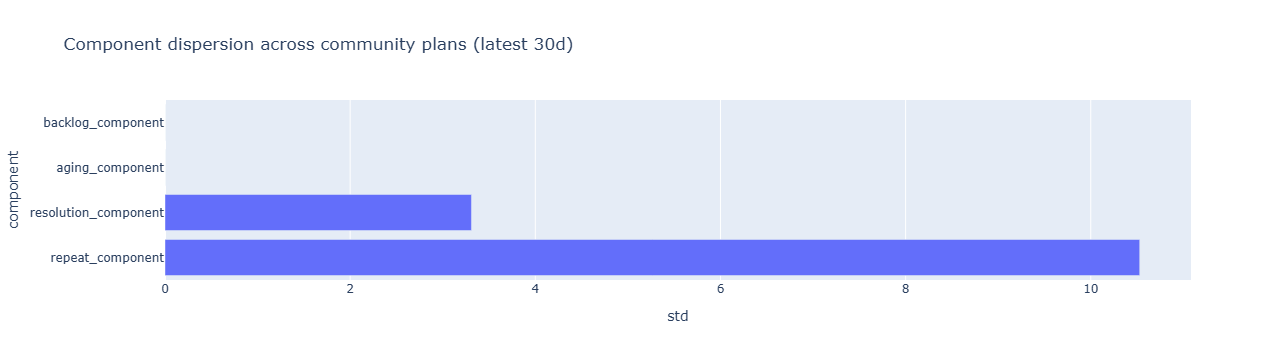

In [6]:
component_cols = ['backlog_component', 'aging_component', 'repeat_component', 'resolution_component']

latest_30 = frustration[
    (frustration['window_days'] == 30)
    & (frustration['grain_type'] == 'comm_plan_name')
    & (frustration['grain_value'] != 'Unknown')
    & (frustration['as_of_date'] == frustration['as_of_date'].max())
].copy()

if latest_30.empty:
    print('No latest 30-day community-plan rows available for sensitivity checks.')
else:
    variance_df = (
        latest_30[component_cols]
        .astype(float)
        .agg(['mean', 'std', 'min', 'max'])
        .T
        .reset_index()
        .rename(columns={'index': 'component'})
        .sort_values('std', ascending=False)
    )
    display(variance_df)

    fig_var = px.bar(
        variance_df,
        x='std',
        y='component',
        orientation='h',
        title='Component dispersion across community plans (latest 30d)',
    )
    fig_var.show()

,component,median_abs_daily_change
0,backlog_component,0.0
1,aging_component,0.0
2,repeat_component,0.0
3,resolution_component,0.0


,backlog_component,aging_component,repeat_component,resolution_component
backlog_component,NaN,NaN,NaN,NaN
aging_component,NaN,NaN,NaN,NaN
repeat_component,NaN,NaN,1.00,0.37
resolution_component,NaN,NaN,0.37,1.00


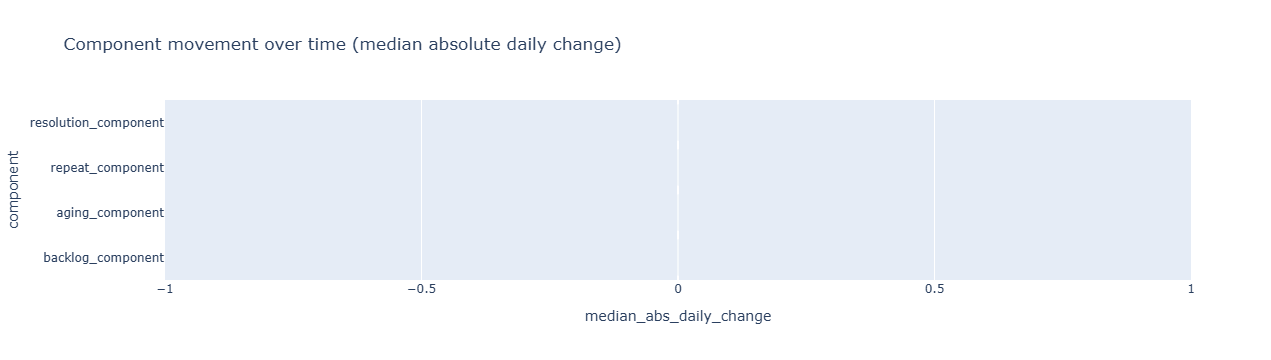

In [7]:
trend_cp = frustration[
    (frustration['window_days'] == 30)
    & (frustration['grain_type'] == 'comm_plan_name')
    & (frustration['grain_value'] != 'Unknown')
].copy()

if trend_cp.empty:
    print('No trend data available for stability/correlation checks.')
else:
    trend_cp['as_of_date'] = pd.to_datetime(trend_cp['as_of_date'])
    for col in component_cols:
        trend_cp[col] = pd.to_numeric(trend_cp[col], errors='coerce')

    daily_change = (
        trend_cp.sort_values(['grain_value', 'as_of_date'])
        .groupby('grain_value')[component_cols]
        .diff()
        .abs()
    )
    stability = daily_change.median().rename('median_abs_daily_change').reset_index().rename(columns={'index': 'component'})

    corr = trend_cp[component_cols].corr().round(2)

    display(stability.sort_values('median_abs_daily_change', ascending=False))
    display(corr)

    fig_stability = px.bar(
        stability,
        x='median_abs_daily_change',
        y='component',
        orientation='h',
        title='Component movement over time (median absolute daily change)',
    )
    fig_stability.show()